In [1]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet_v2 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16,VGG19,ResNet101V2
from keras.models import Model



# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score,roc_curve,roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/dataset_sup_new.zip" -d '/content/dataset'

Archive:  /content/drive/My Drive/dataset_sup_new.zip
   creating: /content/dataset/dataset_sup/
   creating: /content/dataset/dataset_sup/test/
   creating: /content/dataset/dataset_sup/test/caricature/
  inflating: /content/dataset/dataset_sup/test/caricature/001.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/004.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/007.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/008.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/012.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/020.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/022.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/026.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/028.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/031.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/033.jpg  
  inflating: /content/dataset/dataset_sup/test/c

In [ ]:
data_dir = '/content/dataset/dataset_sup/'
train_dir = '/content/dataset/dataset_sup/train'
val_dir = '/content/dataset/dataset_sup/val'
test_dir = '/content/dataset/dataset_sup/test'

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_set = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_set = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_set = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2400 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input


In [ ]:
pre_trained_model = tf.keras.applications.ResNet101V2(input_shape=(224, 224, 3), include_top=False,weights='imagenet')


171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = pre_trained_model(x,training='False')
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0     

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_set,
                    epochs=200,
                    validation_data=validation_set,
                    callbacks=[callback])


Epoch 1/200
75/75 [==============================] - 37s 263ms/step - loss: 2.4444 - acc: 0.7450 - val_loss: 0.6612 - val_acc: 0.9175
Epoch 2/200
75/75 [==============================] - 15s 188ms/step - loss: 0.8818 - acc: 0.8896 - val_loss: 0.4877 - val_acc: 0.9375
Epoch 3/200
75/75 [==============================] - 15s 193ms/step - loss: 0.6726 - acc: 0.9013 - val_loss: 0.3951 - val_acc: 0.9425
Epoch 4/200
75/75 [==============================] - 15s 195ms/step - loss: 0.5172 - acc: 0.9121 - val_loss: 0.4815 - val_acc: 0.9350
Epoch 5/200
75/75 [==============================] - 15s 191ms/step - loss: 0.3977 - acc: 0.9229 - val_loss: 0.3281 - val_acc: 0.9475
Epoch 6/200
75/75 [==============================] - 15s 192ms/step - loss: 0.3186 - acc: 0.9312 - val_loss: 0.4303 - val_acc: 0.9300
Epoch 7/200
75/75 [==============================] - 15s 194ms/step - loss: 0.3297 - acc: 0.9312 - val_loss: 0.3771 - val_acc: 0.9350
Epoch 8/200
75/75 [==============================] - 15s 191ms

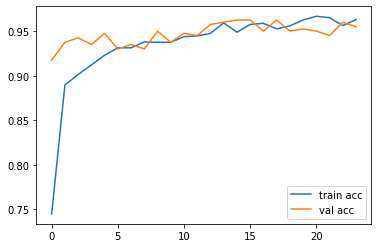

In [ ]:
plt.plot(history.history['acc'], label='train acc')

plt.plot(history.history['val_acc'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

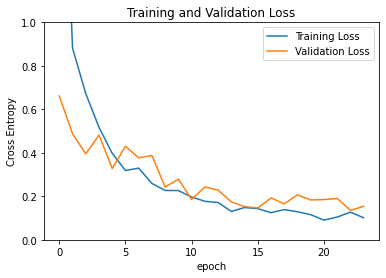

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss0, accuracy0 = model.evaluate(test_set)

38/38 [==============================] - 6s 152ms/step - loss: 0.1756 - acc: 0.9533
